In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 


import plotly
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import norm, skew

from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
import itertools

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('train.csv') 

In [4]:
df.head()

,date,store,item,quantity
0,01-01-13,1,1,13
1,01-02-13,1,1,11
2,01-03-13,1,1,14
3,01-04-13,1,1,13
4,01-05-13,1,1,10


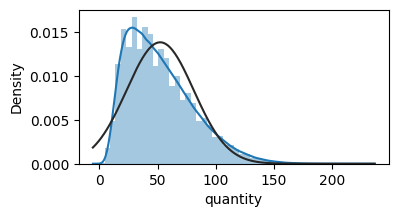

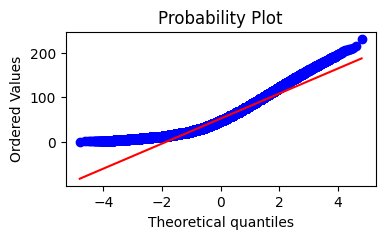

In [5]:
#Lets check the ditribution of the target variable (Order_Demand)
from matplotlib import rcParams
# figure size in inches
rcParams['figure.figsize'] = 4,2

sns.distplot(df['quantity'], fit=norm)

#Get the QQ-plot
fig = plt.figure()
res = stats.probplot(df['quantity'], plot=plt)
plt.show()

In [6]:
df['quantity'].skew()

0.8671122960235805

In [7]:
df['date'] = pd.to_datetime(df['date'])

[Text(0.5, 0, 'Order_Date'), Text(0, 0.5, 'Quantity')]

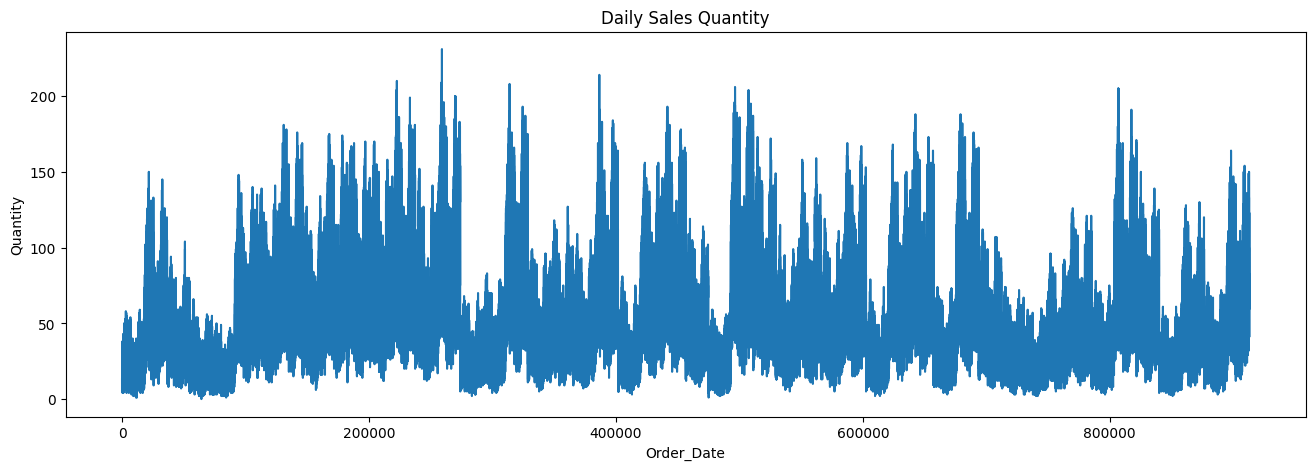

In [8]:
daily_graph = df['quantity'].plot(figsize = (16,5), title="Daily Sales Quantity")
daily_graph.set(xlabel='Order_Date',ylabel='Quantity')

[Text(0.5, 0, 'Order_Date'), Text(0, 0.5, 'Quantity')]

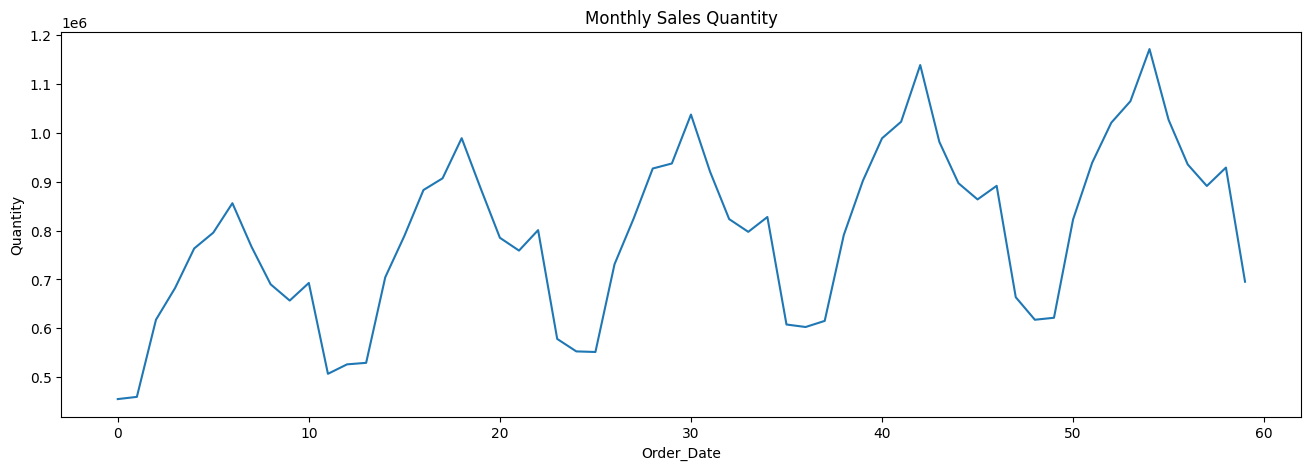

In [9]:
monthly_data = df.groupby([pd.Grouper(key="date",freq='MS')])['quantity'].sum().reset_index().sort_values("date")
monthly_graph = monthly_data['quantity'].plot(figsize = (16,5), title="Monthly Sales Quantity")
monthly_graph.set(xlabel='Order_Date',ylabel='Quantity')   

In [10]:
monthly_data.head()

,date,quantity
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242


In [11]:
df['store_item'] = 'store' + df['store'].astype(str) + '_item' + df['item'].astype(str)


In [12]:
product_ids = ['store2_item28', 'store2_item15', 'store2_item18', 'store8_item15', 'store2_item13']
products = df[df['store_item'].isin(product_ids)]

# Seasonal Descomposition

In [13]:

# # from statsmodels.tsa.seasonal import seasonal_decompose
# # monthly_data.set_index('date', inplace=True)
# # monthly_data.index.freq = 'MS'

# result = seasonal_decompose(monthly_data["quantity"], model="additive")

# plt.figure(figsize=(12, 50))

# # Plot the decomposition components
# result.plot()

# plt.show()

NameError: name 'seasonal_decompose' is not defined

# Stationary Check 

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries, window = 12, cutoff = 0.01):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

#     #Plot rolling statistics:
#     fig = plt.figure(figsize=(12, 8))
#     orig = plt.plot(timeseries, color='blue',label='Original')
#     mean = plt.plot(rolmean, color='red', label='Rolling Mean')
#     std = plt.plot(rolstd, color='black', label = 'Rolling Std')
#     plt.legend(loc='best')
#     plt.title('Rolling Mean & Standard Deviation')
#     plt.show()
    
#     #Perform Dickey-Fuller test:
#     print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', maxlag = 20 )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

In [16]:
test_stationarity(monthly_data['quantity'])

p-value = 0.6262. The series is likely non-stationary.
Test Statistic                 -1.306414
p-value                         0.626233
#Lags Used                     18.000000
Number of Observations Used    41.000000
Critical Value (1%)            -3.600983
Critical Value (5%)            -2.935135
Critical Value (10%)           -2.605963
dtype: float64


In [45]:
def check_stationarity(st_data):
#     Plot the monthly data
#     plt.figure(figsize=(16, 8))
#     plt.plot(st_data, label='Monthly TotalVolume')
#     plt.title(f'Monthly TotalVolume for ')
#     plt.xlabel('Date')
#     plt.ylabel('TotalVolume')
#     plt.legend()
#     plt.show()
    
    #adfuller test
    result = adfuller(st_data['quantity'])
#     labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#     for value,label in zip(result,labels):
#         print(label+' : '+str(value) )
#     if result[1] <= 0.05:
#         print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
#     else:
#         print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    return result[1] <= 0.05

In [21]:
check_stationarity(monthly_data)

ADF Test Statistic : -5.247518850016353
p-value : 7.026495391574688e-06
#Lags Used : 11
Number of Observations Used : 48
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


True

In [22]:
def make_stationary(ts):
    d = 0
    while not check_stationarity(ts):
        ts = ts.diff().dropna()
        d += 1
    return ts, d

In [ ]:

# auto_arima(monthly_data['quantity'], seasonal=True, m=12,max_p=25, max_d=5,max_q=7, max_P=7, max_D=4,max_Q=4).summary()

In [ ]:

# train_data = monthly_data[:len(monthly_data)-12]
# test_data = monthly_data[len(monthly_data)-12:]

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(train_data['quantity'],lags=20,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(train_data['quantity'],lags=20,ax=ax2)

In [ ]:
# arima_model = SARIMAX(train_data['quantity'], order = (0,1,0), seasonal_order = (0,1,0,12))
# arima_result = arima_model.fit()
# arima_result.summary()

In [23]:
def ready_data(df):
    train = pd.DataFrame({
        'date': df[:int(len(df)*0.8)].index, 
        'quantity': df[:int(len(df)*0.8)]['quantity'].values})
    validation = pd.DataFrame({
        'date': df[int(len(df)*0.8):].index, 
        'quantity': df[int(len(df)*0.8):]['quantity'].values})
    return train, validation

In [ ]:
# def apply_sarima(train, test):
#     sarima_model = pm.auto_arima(test["quantity"], 
#                        exogenous=test[['date']],
#                        start_p=1, start_q=1,
#                        test='adf',
#                        max_p=3, max_q=3, m=12,
#                        start_P=0, seasonal=True,
#                        d=None, D=0, 
#                        trace=False,
#                        error_action='ignore',  
#                        suppress_warnings=True, 
#                        stepwise=True)


#     forecast, conf_int = sarima_model.predict(n_periods=len(test), return_conf_int=True)
#     rmse = np.sqrt(mean_squared_error(test['quantity'], forecast))
#     r2 = r2_score(test['quantity'], forecast)
#     return r2, rmse, sarima_model
    

In [24]:
def apply_sarimax(train, test):
    p = d = q = P = D = Q = range(0, 3)
    s = [12]  # Seasonal period

    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = list(itertools.product(P, D, Q, s))

    best_aic = float('inf')
    best_params = None
    best_seasonal_params = None

    for param in pdq:
        for seasonal_param in seasonal_pdq:
            try:
                model = SARIMAX(
                    train['quantity'],
                    exogenous=train[['date']],
                    order=param,
                    seasonal_order=seasonal_param,
                    enforce_stationarity=False,
                    enforce_invertibility=False
                )
                results = model.fit(disp=False)
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = seasonal_param
            except:
                continue

    # Fit 
    sarimax_model = SARIMAX(
        train['quantity'],
        exogenous=train[['date']],
        order=best_params,
        seasonal_order=best_seasonal_params,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)

    forecast = sarimax_model.predict(
        start=len(train),
        end=len(train) + len(test) - 1,
        exogenous=test[['date']],
        dynamic=False
    )

    rmse = np.sqrt(mean_squared_error(test['quantity'], forecast))
    r2 = r2_score(test['quantity'], forecast)

    return r2, rmse, sarimax_model


In [38]:
def apply_sarimax(train, test):
    # Define SARIMAX model parameters
    
    model_score = {}
    
    order = (1, 1, 1)  # (p, d, q)
    seasonal_order = (1, 1, 1, 12)  # (P, D, Q, s)
    
    # Fit the SARIMAX model
    sarimax_model = SARIMAX(
        train['quantity'],
        exogenous=train[['date']],
        order=order,
        seasonal_order=seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit(disp=False)
    
    # Forecasting with SARIMAX model
    forecast = sarimax_model.predict(
        start=len(train), 
        end=len(train) + len(test) - 1,
        exogenous=test[['date']],
        dynamic=False
    )
    
    # Calculate evaluation metrics
    rmse = np.sqrt(mean_squared_error(test['quantity'], forecast))
    r2 = r2_score(test['quantity'], forecast)
    
    return r2, rmse, forecast, sarimax_model


In [ ]:
# import itertools
# from statsmodels.tsa.arima.model import ARIMA

# def apply_arima(train, test):
#     p = d = q = range(0, 3)

#     pdq = list(itertools.product(p, d, q))

#     best_aic = float('inf')
#     best_params = None

#     for param in pdq:
#         try:
#             model = ARIMA(train['quantity'], order=param)
#             results = model.fit(disp=False)
#             if results.aic < best_aic:
#                 best_aic = results.aic
#                 best_params = param
#         except:
#             continue

#     arima_model = ARIMA(train['quantity'], order=best_params).fit(disp=False)

#     forecast = arima_model.predict(
#         start=len(train),
#         end=len(train) + len(test) - 1,
#         dynamic=False
#     )

#     # Calculate evaluation metrics
#     rmse = np.sqrt(mean_squared_error(test['quantity'], forecast))
#     r2 = r2_score(test['quantity'], forecast)

#     return r2, rmse, arima_model

# # Example usage:
# # r2, rmse, arima_model = apply_arima(train, test)
# # print(f'R2: {r2}, RMSE: {rmse}')


60
R2 Score:  0.966526124859292 RMSE Score: 135.79544660031874


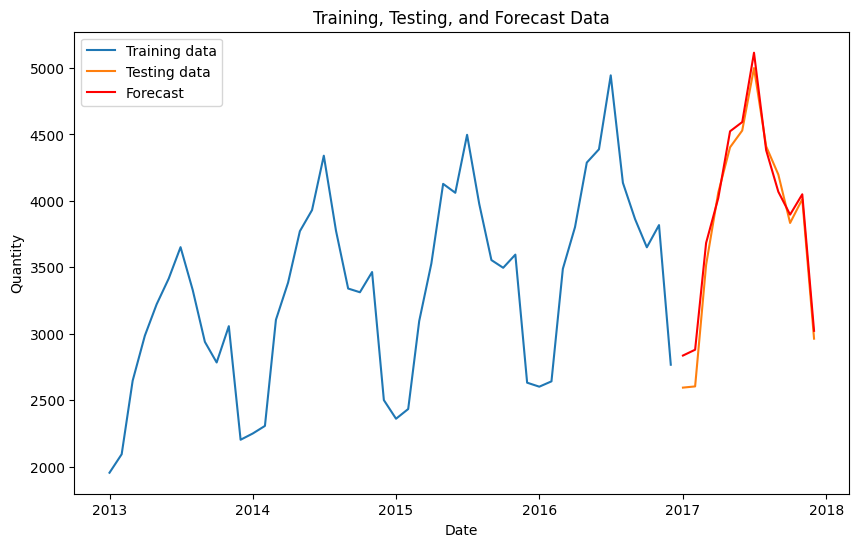

60
R2 Score:  0.9642703557250925 RMSE Score: 137.52471965537612


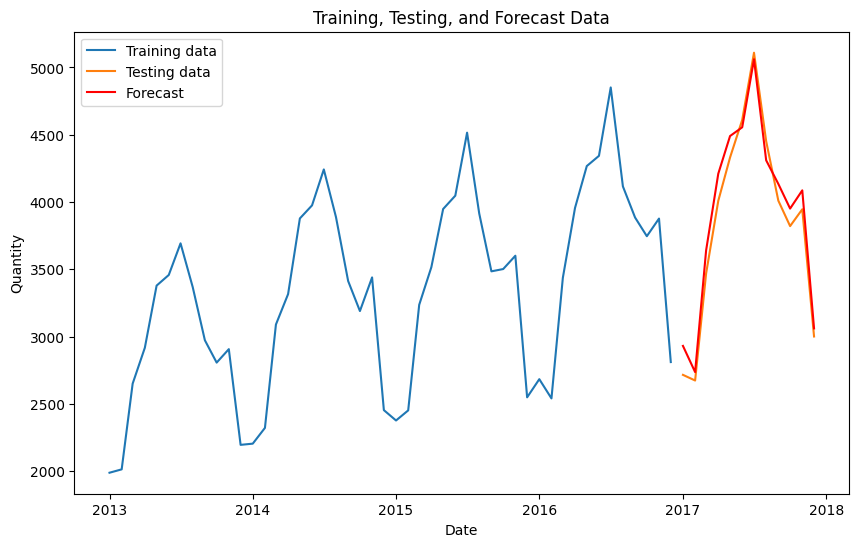

60
R2 Score:  0.9686977898713924 RMSE Score: 128.28409894028468


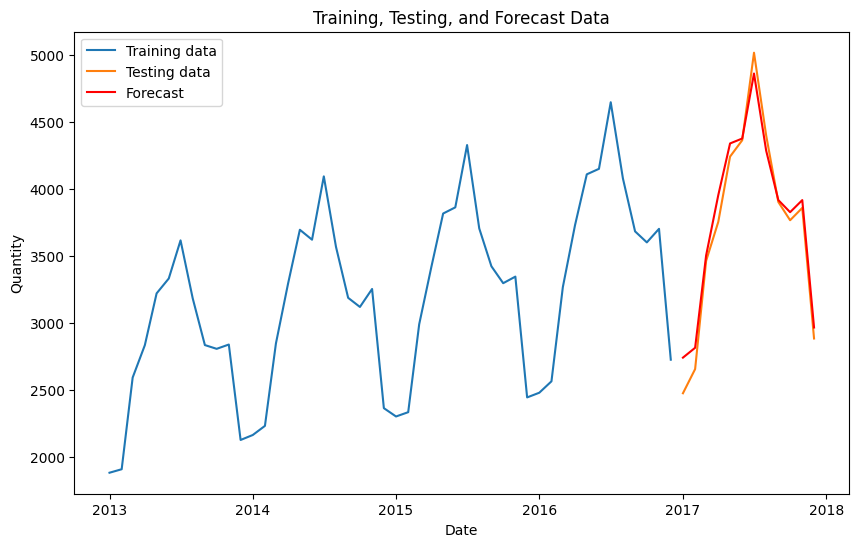

60
R2 Score:  0.9475847954330002 RMSE Score: 156.28228544670267


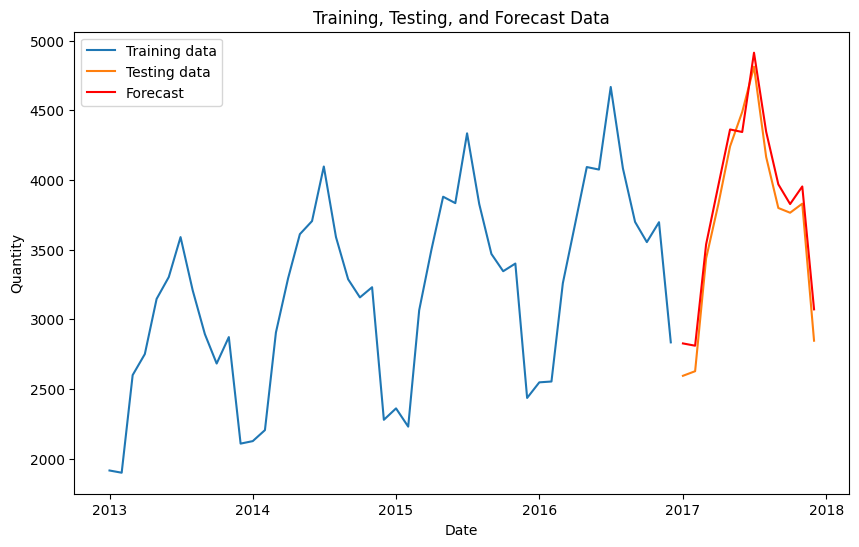

60
R2 Score:  0.9665730306136198 RMSE Score: 131.26479524427958


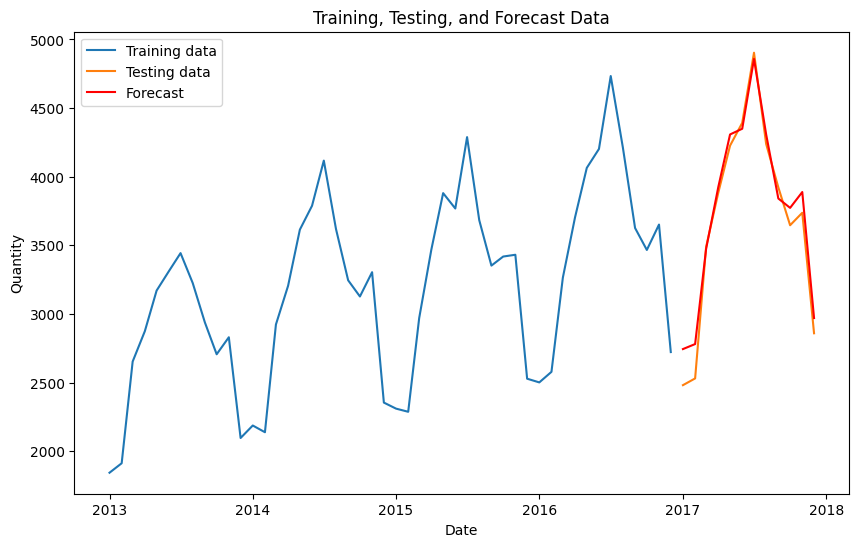

In [48]:

model_score = {}
for product in product_ids:
    data = products[products['store_item'] == product]
    data = data.drop('store_item', axis =1).set_index('date')
    data = data.resample('MS').sum()
    print(len(data))
    
    if not (check_stationarity(data)):
        data, d = make_stationary(data)
    
    
    train, test = ready_data(data)
    
    r2, rmse, forecast, model = apply_sarimax(train, test)
    model_score[product] = {'r2': r2, 'rmse': rmse, 'model': model}
    
    
    # Plotting 
    print("R2 Score: ", r2, "RMSE Score:", rmse)
    model = model_score[product]['model']
#     forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

    plt.figure(figsize=(10, 6))
    plt.plot(train['date'], train['quantity'], label='Training data')
    plt.plot(test['date'], test['quantity'], label='Testing data')
    plt.plot(test['date'], forecast, color='red', label='Forecast')
#     plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
    plt.xlabel('Date')
    plt.ylabel('Quantity')
    plt.title('Training, Testing, and Forecast Data')
    plt.legend()
    plt.show()